*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/adverbial_components.ipynb)*

# Time Adverbial Components
### Cody Kingham
<a href="../../docs/sponsors.md"><img height=200px width=200px align="left" src="../../docs/images/CambridgeU_BW.png"></a>

In [1]:
! echo "last updated:"; date

last updated:
Tue  9 Jun 2020 18:00:26 BST


## Introduction

This notebook will produce data for my in-progress article on time adverbial components. 

<hr>

# Python

Now we import the modules and data needed for the analysis.

In [2]:
# standard & data science packages
import collections
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['SBL Biblit']
pd.set_option('display.max_rows', 100)
import seaborn as sns
from bidi.algorithm import get_display # bi-directional text support for plotting
from sklearn.metrics.pairwise import cosine_similarity

# custom packages (see /tools)
import paths
import stats.significance as mystats
import stats.pca as my_pca
from tf_tools.load import load_tf
from positions import Walker, Positions
import tf_tools.formatting as form

# load time cx data
from cx_analysis.load import cxs
times_full = pd.read_csv(paths.main_table, sep='\t')
times_full.set_index(['node'], inplace=True)
times = pd.DataFrame(times_full[~times_full.classi.str.contains('component')]) # select singles

# launch Text-Fabric with custom data
TF, API, A = load_tf('funct_assoc nhead top_assoc', silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L # corpus analysis methods

# import single subphrasal phrases for all constructions
all_functions_data = paths.data.joinpath('all_function_cxs/function_data.csv')
functs_df = pd.read_csv(all_functions_data)
functs_df.set_index(['node'], inplace=True)

def savefig(name):
    """Formats filename and save a figure"""
    file_name = paths.figs.joinpath(f'ta_components/{name}.svg')
    plt.savefig(file_name, format='svg', bbox_inches='tight')

# Rough Dataset for All Phrase Functions

`functs_df` contains precision data for the functions `{'Time', 'Subj', 'Objc', 'Loca', 'Adju', 'Cmpl'}`.<br>
But this data represents just a subset of all phrases in the Hebrew Bible.

objective: produce and analyze data on the subset of samples to test for representation and dispersion.<br>
How representative can the subset be for each function?

In [3]:
phrase_dataset = []

for phrase in F.otype.s('phrase'):
    
    # exclude Aramaic portions
    lang = F.language.v(L.d(phrase,'word')[0])
    if lang != 'Hebrew':
        continue
    
    book, chapter, verse = T.sectionFromNode(phrase)
    book_sbl = form.book2sbl[book]
    sentence = L.u(phrase, 'sentence')[0]
    ref = f'{form.book2sbl[book]} {chapter}:{verse}'
    function = F.function.v(phrase)
    s_function = form.simplified_functions.get(function, function)
    n_words = len(L.d(phrase, 'word'))
    n_phrase_atoms = len(L.d(phrase, 'phrase_atom'))
    heads = E.nhead.t(phrase)
    n_heads = len(heads)
    first_head = heads[0]
    head_lexs = '|'.join(F.lex.v(h) for h in heads)
    head_utf8 = '|'.join(T.text(h).strip() for h in heads)
    head_lexnodes = tuple(L.u(h,'lex')[0] for h in heads)
    daughters = E.mother.t(phrase)
    n_daughters = len(daughters)
    mothers = E.mother.f(phrase)
    n_mothers = len(mothers)
    d_relas = '|'.join(F.rela.v(d) for d in daughters)
    ph_typ = F.typ.v(phrase)
    rela = F.rela.v(phrase)
    time_phrase = L.u(phrase, 'timephrase')
    parsed = phrase in functs_df.index
    parsed = 1 if parsed else 0
    
    phrase_dataset.append({
        'node': phrase,
        'ref': ref,
        'book': book_sbl,
        'text': T.text(phrase),
        'sentence': T.text(sentence),
        'type': ph_typ,
        'function': function,
        's_function': s_function,
        'rela': rela,
        'n_words': n_words,
        'n_phrase_atoms': n_phrase_atoms,
        'n_heads': n_heads,
        'head_lex': head_lexs,
        'head_lex_nodes': head_lexnodes,
        'n_daughters': n_daughters,
        'daught_relas': d_relas or np.nan,
        'n_mothers': n_mothers,
        'n_relas': n_daughters + n_mothers,
        'in_timephrase': bool(time_phrase),
        'parsed': parsed,
    })
    
print(len(phrase_dataset), 'phrases collected...')

249382 phrases collected...


In [4]:
phrase_df = pd.DataFrame(phrase_dataset)
phrase_df.set_index('node', inplace=True)

In [5]:
phrase_df.head()

,ref,book,text,sentence,type,function,s_function,rela,n_words,n_phrase_atoms,n_heads,head_lex,head_lex_nodes,n_daughters,daught_relas,n_mothers,n_relas,in_timephrase,parsed
node,,,,,,,,,,,,,,,,,,,
651542,Gen 1:1,Gen,בְּרֵאשִׁ֖ית,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Time,Time,NA,2,1,1,R>CJT/,"(1437568,)",0,NaN,0,0,True,1
651543,Gen 1:1,Gen,בָּרָ֣א,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,VP,Pred,Pred,NA,1,1,1,BR>[,"(1437569,)",0,NaN,0,0,False,0
651544,Gen 1:1,Gen,אֱלֹהִ֑ים,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,NP,Subj,Subj,NA,1,1,1,>LHJM/,"(1437570,)",0,NaN,0,0,False,1
651545,Gen 1:1,Gen,אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Objc,Objc,NA,7,1,2,CMJM/|>RY/,"(1437573, 1437575)",0,NaN,0,0,False,0
651546,Gen 1:2,Gen,וְ,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,CP,Conj,Conj,NA,1,1,1,W,"(1437574,)",0,NaN,0,0,False,0


## Examine effects of each selection for sample across selection criteria

In [6]:
# we build a series of pivot tables and proportion data calculated
# from the tables; to configure each table, we load valeus into a dictionary

# store settings to build all tables
table_settings = {
    'n_atoms': {                          # name of table
        'cols': ['n_phrase_atoms'],       # name of cols to cross tabulate with function
        'sum_column': 1,                  # name or list of cols to sum versus others
        'new_cols': ('na = 1', 'na > 1'), # label for new columns
    },
    'n_heads': {
        'cols': ['n_heads'],
        'sum_column': 1,
        'new_cols': ('nh = 1', 'nh > 1')
    },
    'n_relas': {
        'cols': ['n_relas'],
        'sum_column': 0,
        'new_cols': ('nr = 0', 'nr > 0'),
    },
    'n_parsed': {
        'cols': ['parsed'],
        'sum_column': 1,
        'new_cols': ('y', 'n')
    },
#     'n_all': {
#         'cols': ['n_phrase_atoms', 'n_heads', 'n_relas', 'parsed'],
#         'sum_column': (1, 1, 0, 1),
#         'new_cols': ('sample', 'others'),
#     }
}

# define sample
functions_sample = sorted([
    'Adju',
    'Cmpl',
    'Loca',
    'Objc',
    'Subj',
    'Time',
])
funct_sample = phrase_df[phrase_df.s_function.isin(functions_sample)]

pivots = {}
for name, setting in table_settings.items():
    
    # build pivot tables that count all of the set columns
    # as they appear together
    pivots[name] = pd.pivot_table(
        funct_sample, 
        index='s_function',
        columns=setting['cols'],
        aggfunc='size',
        fill_value=0,
    )

    
# make summaries 
sums = {}
for name, setting in table_settings.items():
    pivot = pivots[name]
    first_sum = pivot[setting['sum_column']]
    second_sum = pivot.drop(columns=setting['sum_column']).sum(1)    
    new_table = pd.concat([first_sum, second_sum], 1)
    new_table.columns = setting['new_cols']
    sums[name] = new_table
    
    
props = {}
for name, table in sums.items():
    props[name] = table.div(table.sum(1), 0)
    
props.keys()

dict_keys(['n_atoms', 'n_heads', 'n_relas', 'n_parsed'])

Make the subplots.

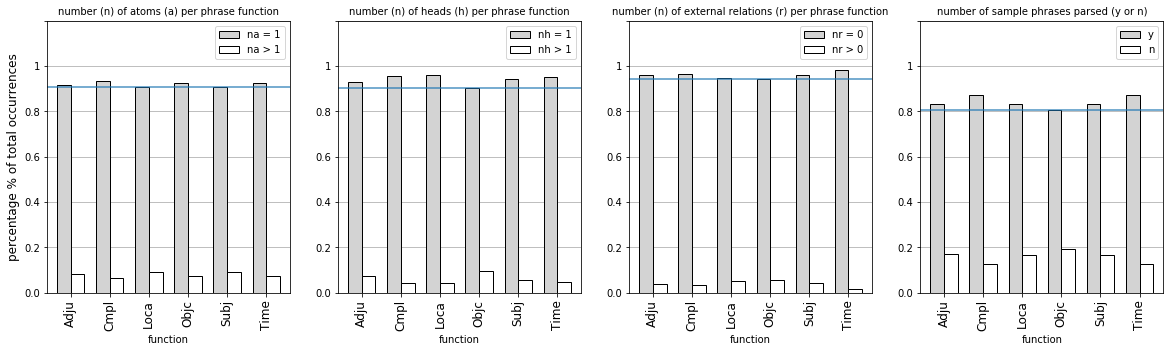

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

props['n_atoms'].plot(kind='bar', ax=ax1, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax1.axhline(props['n_atoms']['na = 1'].min(), alpha=0.8)
ax1.set_title('number (n) of atoms (a) per phrase function', size=10)

props['n_heads'].plot(kind='bar', ax=ax2, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax2.axhline(props['n_heads']['nh = 1'].min(), alpha=0.8)
ax2.set_title('number (n) of heads (h) per phrase function', size=10)

props['n_relas'].plot(kind='bar', ax=ax3, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax3.axhline(props['n_relas']['nr = 0'].min(), alpha=0.8)
ax3.set_title('number (n) of external relations (r) per phrase function', size=10)

props['n_parsed'].plot(kind='bar', ax=ax4, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax4.axhline(props['n_parsed']['y'].min(), alpha=0.8)
ax4.set_title('number of sample phrases parsed (y or n)', size=10)

# props['n_all'].plot(kind='bar', ax=ax5, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
# ax5.axhline(props['n_all']['sample'].min(), alpha=0.8)
# ax5.set_title('number of sampled versus excluded phrases', size=10)

axes = (ax1, ax2, ax3, ax4)

ax1.set_ylabel('percentage % of total occurrences', size=12)

for ax, data in zip(axes, props):
    
    ax.set_ylim(0, 1.2)
    ax.grid(axis='y')
    ax.set_axisbelow(True) 
    ax.set_xlabel('function', size=10)
    ax.set_xticklabels(ax.get_xticklabels(), size=12)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1])
    
savefig('funct_sample')

In [8]:
props['n_parsed'].T.sort_values(by='y', axis=1)

s_function,Objc,Adju,Subj,Loca,Cmpl,Time
y,0.806913,0.831029,0.832893,0.834167,0.873647,0.874726
n,0.193087,0.168971,0.167107,0.165833,0.126353,0.125274


In [9]:
props['n_parsed']['y'].mean()

0.8422291582028945

In [10]:
sums['n_parsed']

,y,n
s_function,,
Adju,7815,1589
Cmpl,25832,3736
Loca,2168,431
Objc,18070,4324
Subj,26172,5251
Time,3987,571


In [11]:
pd.DataFrame(sums['n_parsed']['y']).T.to_clipboard()

In [12]:
# total sample size
sums['n_parsed'].sum()

y    84044
n    15902
dtype: int64

## Deviation of Proportions

Now we'll look to see how representative the datasample is across the<br>
Hebrew Bible. Have the selection requirements negatively affected any of the books?

In [13]:
# make a cross-tabulation from function to 
# book, n_pa, n_heads, and n_daughters to 
# enable selection of data as needed

by_book = pd.pivot_table(
    funct_sample, 
    index='s_function', 
    columns=['n_phrase_atoms', 'n_heads', 'n_relas', 'parsed', 'book'], 
    aggfunc='size', 
    fill_value=0
)

# result is a multi-index df
by_book.head()

n_phrase_atoms    1                                                ...  12  \
n_heads            1                                               ...   2   
n_relas            0                                               ...   0   
parsed             0                                               ...   0   
book           1 Kgs 1 Sam 2 Kgs 2 Sam Deut Eccl Ezek Gen Isa Jer  ... Gen   
s_function                                                         ...       
Adju               1     0     0     0    0    0    0   0   0   0  ...   0   
Cmpl               0     0     0     0    0    0    1   2   1   0  ...   1   
Loca               0     0     0     0    0    0    0   0   0   0  ...   0   
Objc               0     0     0     0    0    2    1   6   0   1  ...   0   
Subj               1     1     1     2    2   13    1   2   3   0  ...   0   

n_phrase_atoms                        13    14          15  16  
n_heads            4             5     4     5           1   6  
n_relas            0             0     0     0           0   0  
parsed             0             0     0     0           0   0  
book           1 Kgs 2 Chr Jer Gen 2 Kgs 1 Chr 2 Kgs 2 Chr Jer  
s_function                                                      
Adju               0     0   0   0     0     0     0     0   0  
Cmpl               1     0   0   0     0     0     0     0   0  
Loca               0     0   0   0     0     0     0     0   0  
Objc               0     1   0   0     0     0     1     1   0  
Subj               0     0   1   1     1     1     0     0   1  

[5 rows x 1108 columns]

### Does the sample selection affect book-by-book representation of functions?

In [14]:
# exp_prop is a table of ratios which state 
# what proportion of a function's total uses is represented within a given book
# the observed proportion will be that subset of phrases that fit our selection
# criteria, i.e. na=1, nh=1, nd=0
exp_freq = by_book.groupby(axis=1, level='book').sum() # group by book column
exp_prop = exp_freq.div(exp_freq.sum(1), 0)

# observed proportion is the ratio of the selected sample function's
# total representation within a given book: in this case only functions
# which have 1 atom, 1 head, 0 relas, and parse value of 1
obv_freq = by_book[(1, 1, 0, 1)] # select multindex
obv_prop = obv_freq.div(obv_freq.sum(1), 0)

# the deviation of proportions will be the DIFFERENCE between the expected ratios 
# (calculated across the whole dataset) and the ratios across the selected subset
# of phrases
deviation_prop = round(exp_prop - obv_prop, 2)

In [15]:
exp_freq

book,1 Chr,1 Kgs,1 Sam,2 Chr,2 Kgs,2 Sam,Amos,Dan,Deut,Eccl,...,Nah,Neh,Num,Obad,Prov,Ps,Ruth,Song,Zech,Zeph
s_function,,,,,,,,,,,,,,,,,,,,,
Adju,420,309,169,515,237,235,48,95,377,86,...,20,160,432,8,244,908,22,59,88,20
Cmpl,639,1342,1695,1273,1314,1229,225,253,1546,196,...,53,444,1603,29,532,1927,160,125,309,74
Loca,61,130,81,114,123,87,29,9,199,40,...,2,65,156,2,22,126,23,6,21,3
Objc,573,865,826,911,790,628,206,134,1055,190,...,51,284,1062,19,732,1998,75,56,200,65
Subj,1362,1318,1686,1167,1129,1380,187,222,1152,426,...,84,536,1520,39,1090,2127,148,183,356,76
Time,113,200,270,205,193,199,27,56,224,38,...,11,108,203,11,60,320,27,5,65,16


In [16]:
exp_prop

book,1 Chr,1 Kgs,1 Sam,2 Chr,2 Kgs,2 Sam,Amos,Dan,Deut,Eccl,...,Nah,Neh,Num,Obad,Prov,Ps,Ruth,Song,Zech,Zeph
s_function,,,,,,,,,,,,,,,,,,,,,
Adju,0.044662,0.032858,0.017971,0.054764,0.025202,0.024989,0.005104,0.010102,0.040089,0.009145,...,0.002127,0.017014,0.045938,0.000851,0.025946,0.096555,0.002339,0.006274,0.009358,0.002127
Cmpl,0.021611,0.045387,0.057325,0.043053,0.044440,0.041565,0.007610,0.008557,0.052286,0.006629,...,0.001792,0.015016,0.054214,0.000981,0.017992,0.065172,0.005411,0.004228,0.010450,0.002503
Loca,0.023471,0.050019,0.031166,0.043863,0.047326,0.033474,0.011158,0.003463,0.076568,0.015391,...,0.000770,0.025010,0.060023,0.000770,0.008465,0.048480,0.008850,0.002309,0.008080,0.001154
Objc,0.025587,0.038626,0.036885,0.040681,0.035277,0.028043,0.009199,0.005984,0.047111,0.008484,...,0.002277,0.012682,0.047423,0.000848,0.032687,0.089220,0.003349,0.002501,0.008931,0.002903
Subj,0.043344,0.041944,0.053655,0.037138,0.035929,0.043917,0.005951,0.007065,0.036661,0.013557,...,0.002673,0.017058,0.048372,0.001241,0.034688,0.067689,0.004710,0.005824,0.011329,0.002419
Time,0.024792,0.043879,0.059237,0.044976,0.042343,0.043659,0.005924,0.012286,0.049144,0.008337,...,0.002413,0.023695,0.044537,0.002413,0.013164,0.070206,0.005924,0.001097,0.014261,0.003510


In [17]:
obv_freq

book,1 Chr,1 Kgs,1 Sam,2 Chr,2 Kgs,2 Sam,Amos,Dan,Deut,Eccl,...,Nah,Neh,Num,Obad,Prov,Ps,Ruth,Song,Zech,Zeph
s_function,,,,,,,,,,,,,,,,,,,,,
Adju,326,223,138,381,183,197,45,80,286,71,...,20,119,317,7,234,823,15,52,69,19
Cmpl,534,1102,1514,998,1122,1074,205,208,1265,181,...,52,375,1418,28,513,1808,147,106,272,65
Loca,51,101,74,92,102,79,29,9,137,39,...,2,51,131,2,19,112,23,6,17,3
Objc,382,636,688,615,583,499,185,105,755,149,...,50,206,814,18,687,1797,65,52,170,59
Subj,998,1038,1492,847,872,1107,167,182,798,365,...,77,330,1192,35,976,1950,129,161,316,69
Time,94,167,248,164,153,184,24,46,204,32,...,11,82,181,11,56,279,26,3,55,14


In [18]:
obv_prop

book,1 Chr,1 Kgs,1 Sam,2 Chr,2 Kgs,2 Sam,Amos,Dan,Deut,Eccl,...,Nah,Neh,Num,Obad,Prov,Ps,Ruth,Song,Zech,Zeph
s_function,,,,,,,,,,,,,,,,,,,,,
Adju,0.041715,0.028535,0.017658,0.048752,0.023417,0.025208,0.005758,0.010237,0.036596,0.009085,...,0.002559,0.015227,0.040563,0.000896,0.029942,0.105310,0.001919,0.006654,0.008829,0.002431
Cmpl,0.020672,0.042660,0.058609,0.038634,0.043434,0.041576,0.007936,0.008052,0.048970,0.007007,...,0.002013,0.014517,0.054893,0.001084,0.019859,0.069991,0.005691,0.004103,0.010530,0.002516
Loca,0.023524,0.046587,0.034133,0.042435,0.047048,0.036439,0.013376,0.004151,0.063192,0.017989,...,0.000923,0.023524,0.060424,0.000923,0.008764,0.051661,0.010609,0.002768,0.007841,0.001384
Objc,0.021140,0.035196,0.038074,0.034034,0.032263,0.027615,0.010238,0.005811,0.041782,0.008246,...,0.002767,0.011400,0.045047,0.000996,0.038019,0.099447,0.003597,0.002878,0.009408,0.003265
Subj,0.038132,0.039661,0.057007,0.032363,0.033318,0.042297,0.006381,0.006954,0.030491,0.013946,...,0.002942,0.012609,0.045545,0.001337,0.037292,0.074507,0.004929,0.006152,0.012074,0.002636
Time,0.023577,0.041886,0.062202,0.041134,0.038375,0.046150,0.006020,0.011537,0.051166,0.008026,...,0.002759,0.020567,0.045398,0.002759,0.014046,0.069977,0.006521,0.000752,0.013795,0.003511


In [19]:
deviation_prop

book,1 Chr,1 Kgs,1 Sam,2 Chr,2 Kgs,2 Sam,Amos,Dan,Deut,Eccl,...,Nah,Neh,Num,Obad,Prov,Ps,Ruth,Song,Zech,Zeph
s_function,,,,,,,,,,,,,,,,,,,,,
Adju,0.00,0.0,0.0,0.01,0.0,-0.0,-0.0,-0.0,0.00,0.0,...,-0.0,0.0,0.01,-0.0,-0.00,-0.01,0.0,-0.0,0.0,-0.0
Cmpl,0.00,0.0,-0.0,0.00,0.0,-0.0,-0.0,0.0,0.00,-0.0,...,-0.0,0.0,-0.00,-0.0,-0.00,-0.00,-0.0,0.0,-0.0,-0.0
Loca,-0.00,0.0,-0.0,0.00,0.0,-0.0,-0.0,-0.0,0.01,-0.0,...,-0.0,0.0,-0.00,-0.0,-0.00,-0.00,-0.0,-0.0,0.0,-0.0
Objc,0.00,0.0,-0.0,0.01,0.0,0.0,-0.0,0.0,0.01,0.0,...,-0.0,0.0,0.00,-0.0,-0.01,-0.01,-0.0,-0.0,-0.0,-0.0
Subj,0.01,0.0,-0.0,0.00,0.0,0.0,-0.0,0.0,0.01,-0.0,...,-0.0,0.0,0.00,-0.0,-0.00,-0.01,-0.0,-0.0,-0.0,-0.0
Time,0.00,0.0,-0.0,0.00,0.0,-0.0,-0.0,0.0,-0.00,0.0,...,-0.0,0.0,-0.00,-0.0,-0.00,0.00,-0.0,0.0,0.0,-0.0


In [20]:
deviation_prop.abs().sum(0).sort_values(ascending=False)[:15]

book
Deut     0.03
Ps       0.03
Isa      0.02
Job      0.02
2 Chr    0.02
1 Chr    0.01
Josh     0.01
Gen      0.01
Num      0.01
Prov     0.01
2 Kgs    0.00
2 Sam    0.00
Amos     0.00
Hab      0.00
Eccl     0.00
dtype: float64

In [21]:
deviation_prop.mean(0)

book
1 Chr    0.001667
1 Kgs    0.000000
1 Sam    0.000000
2 Chr    0.003333
2 Kgs    0.000000
2 Sam    0.000000
Amos     0.000000
Dan      0.000000
Deut     0.005000
Eccl     0.000000
Esth     0.000000
Exod     0.000000
Ezek     0.000000
Ezra     0.000000
Gen     -0.001667
Hab      0.000000
Hag      0.000000
Hos      0.000000
Isa     -0.003333
Jer      0.000000
Job     -0.003333
Joel     0.000000
Jonah    0.000000
Josh     0.001667
Judg     0.000000
Lam      0.000000
Lev      0.000000
Mal      0.000000
Mic      0.000000
Nah      0.000000
Neh      0.000000
Num      0.001667
Obad     0.000000
Prov    -0.001667
Ps      -0.005000
Ruth     0.000000
Song     0.000000
Zech     0.000000
Zeph     0.000000
dtype: float64

**Based on this data, we can say that the filtered selection of phrase functions<br>
does not negatively affect representation across the Hebrew Bible. The deviation<br>
of proportions is very small across both book and function categories.**

### How evenly distributed is Time compared to the other key functions? (DP)

We can answer this question using DP (Gries 2008), the Degree of Dispersion.<br>

For a given sample (e.g. Hebrew Bible), divide the sample into its various parts (books).<br> 
Use a baseline (e.g. n-phrases) to calculate what proportion each part *should* account<br>
for in the dataset. And compare the observed proportion for a given variable (in this case<br>
function).

In [22]:
# expected proportional representation of total number 
# of phrases for any given book; retrieved by dividing 
# a book's total phrases by the marginal total of all books' n-phrases
book_exp_props = exp_freq.sum(0) / exp_freq.sum(0).sum()

# observed proportional representation for any given book
# of a given function's total occurrences
book_obv_prop = exp_freq.div(exp_freq.sum(1), 0)

# calculate the deviation of proportion of the observed
# proportional representation from the expected proportion
book_dev_prop = book_obv_prop.sub(book_exp_props, 1)

# calculate DP score following Gries 2008 by summing absolute
# value of all deviations per function and dividing by 2
# the resulting score ranges from 0 to 1 where 0 is the 
# hypothetical perfectly distributed function and 1 is the 
# hypothetical worst distributed function
book_DP = abs(book_dev_prop).sum(1) / 2
book_DP = book_DP.sort_values()

In [23]:
book_exp_props.sort_values(ascending=False)

book
Ps       0.074100
Gen      0.069948
Jer      0.066416
Ezek     0.061793
Isa      0.059112
Exod     0.056260
Num      0.049787
1 Sam    0.047296
Deut     0.045555
2 Chr    0.041873
1 Kgs    0.041662
Lev      0.038721
2 Kgs    0.037880
2 Sam    0.037600
Judg     0.034138
Job      0.032538
1 Chr    0.031697
Josh     0.029786
Prov     0.026814
Neh      0.015979
Zech     0.010396
Esth     0.009855
Eccl     0.009765
Hos      0.009165
Dan      0.007694
Amos     0.007224
Ezra     0.007124
Lam      0.006173
Mic      0.005283
Ruth     0.004552
Song     0.004342
Joel     0.003562
Mal      0.003272
Hab      0.002661
Jonah    0.002621
Zeph     0.002541
Nah      0.002211
Hag      0.001521
Obad     0.001081
dtype: float64

In [24]:
book_dev_prop

book,1 Chr,1 Kgs,1 Sam,2 Chr,2 Kgs,2 Sam,Amos,Dan,Deut,Eccl,...,Nah,Neh,Num,Obad,Prov,Ps,Ruth,Song,Zech,Zeph
s_function,,,,,,,,,,,,,,,,,,,,,
Adju,0.012965,-0.008804,-0.029324,0.012891,-0.012678,-0.012611,-0.002120,0.002408,-0.005465,-0.000620,...,-0.000084,0.001035,-0.003849,-0.000230,-0.000868,0.022455,-0.002213,0.001932,-0.001038,-0.000415
Cmpl,-0.010086,0.003724,0.010030,0.001181,0.006559,0.003965,0.000386,0.000862,0.006732,-0.003136,...,-0.000419,-0.000962,0.004427,-0.000100,-0.008822,-0.008928,0.000859,-0.000115,0.000055,-0.000039
Loca,-0.008227,0.008357,-0.016130,0.001990,0.009445,-0.004126,0.003934,-0.004231,0.031013,0.005625,...,-0.001442,0.009031,0.010236,-0.000311,-0.018350,-0.025620,0.004297,-0.002034,-0.002316,-0.001387
Objc,-0.006110,-0.003036,-0.010411,-0.001192,-0.002603,-0.009557,0.001975,-0.001710,0.001556,-0.001281,...,0.000066,-0.003297,-0.002363,-0.000232,0.005873,0.015120,-0.001203,-0.001842,-0.001465,0.000361
Subj,0.011647,0.000281,0.006359,-0.004734,-0.001951,0.006317,-0.001273,-0.000629,-0.008894,0.003792,...,0.000462,0.001079,-0.001415,0.000161,0.007873,-0.006411,0.000157,0.001481,0.000934,-0.000123
Time,-0.006906,0.002216,0.011941,0.003103,0.004463,0.006059,-0.001300,0.004592,0.003590,-0.001428,...,0.000202,0.007716,-0.005250,0.001333,-0.013651,-0.003894,0.001371,-0.003245,0.003865,0.000969


In [25]:
book_DP

s_function
Subj    0.052235
Objc    0.059881
Cmpl    0.072055
Time    0.083187
Loca    0.146092
Adju    0.156321
dtype: float64

**Time**

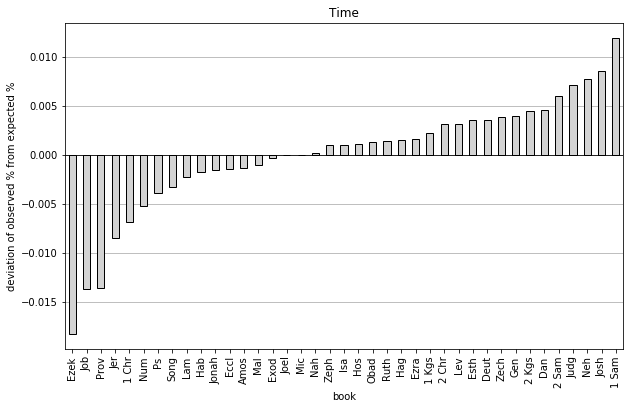

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
book_dev_prop.loc['Time'].sort_values().plot(kind='bar', ax=ax, color='lightgray', edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y')
ax.set_axisbelow(True) 
ax.set_ylabel('deviation of observed % from expected %', size=10)
ax.set_title('Time')
savefig('DP_book_Time')
plt.show()

In [27]:
book_dev_prop.loc['Time'].sort_values()

book
Ezek    -0.018353
Job     -0.013670
Prov    -0.013651
Jer     -0.008496
1 Chr   -0.006906
Num     -0.005250
Ps      -0.003894
Song    -0.003245
Lam     -0.002224
Hab     -0.001784
Jonah   -0.001524
Eccl    -0.001428
Amos    -0.001300
Mal     -0.001078
Exod    -0.000315
Joel    -0.000052
Mic     -0.000017
Nah      0.000202
Zeph     0.000969
Isa      0.001002
Hos      0.001147
Obad     0.001333
Ruth     0.001371
Hag      0.001551
Ezra     0.001652
1 Kgs    0.002216
2 Chr    0.003103
Lev      0.003183
Esth     0.003528
Deut     0.003590
Zech     0.003865
Gen      0.003988
2 Kgs    0.004463
Dan      0.004592
2 Sam    0.006059
Judg     0.007108
Neh      0.007716
Josh     0.008608
1 Sam    0.011941
Name: Time, dtype: float64

**Adjunct**

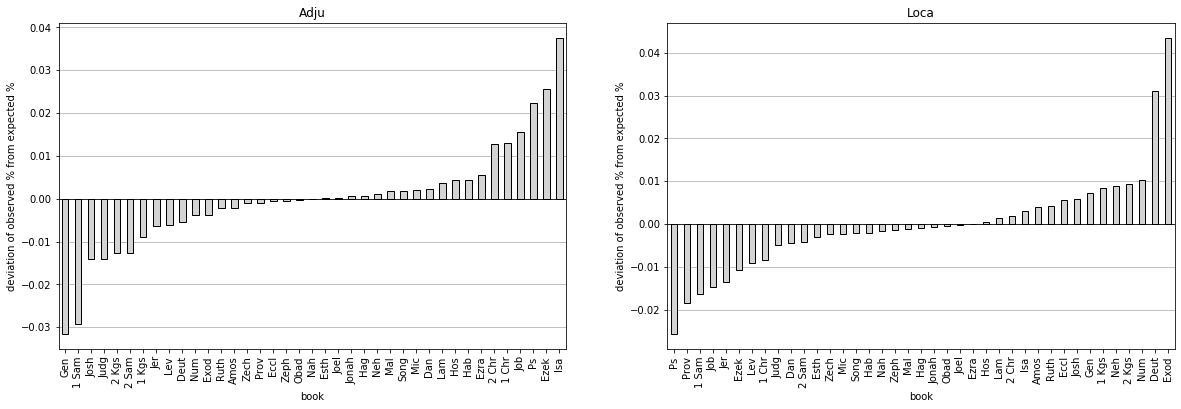

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax = ax1
book_dev_prop.loc['Adju'].sort_values().plot(kind='bar', ax=ax, color='lightgray', edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y')
ax.set_axisbelow(True) 
ax.set_ylabel('deviation of observed % from expected %', size=10)
ax.set_title('Adju')

ax=ax2
book_dev_prop.loc['Loca'].sort_values().plot(kind='bar', ax=ax, color='lightgray', edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y')
ax.set_axisbelow(True) 
ax.set_ylabel('deviation of observed % from expected %', size=10)
ax.set_title('Loca')

savefig('DP_book_Adju_Loca')

plt.show()

In [29]:
book_dev_prop.loc['Adju'].sort_values()

book
Gen     -0.031666
1 Sam   -0.029324
Josh    -0.014048
Judg    -0.013934
2 Kgs   -0.012678
2 Sam   -0.012611
1 Kgs   -0.008804
Jer     -0.006335
Lev     -0.006182
Deut    -0.005465
Num     -0.003849
Exod    -0.003836
Ruth    -0.002213
Amos    -0.002120
Zech    -0.001038
Prov    -0.000868
Eccl    -0.000620
Zeph    -0.000415
Obad    -0.000230
Nah     -0.000084
Esth     0.000247
Joel     0.000266
Jonah    0.000569
Hag      0.000712
Neh      0.001035
Mal      0.001832
Song     0.001932
Mic      0.002054
Dan      0.002408
Lam      0.003716
Hos      0.004340
Hab      0.004357
Ezra     0.005637
2 Chr    0.012891
1 Chr    0.012965
Job      0.015633
Ps       0.022455
Ezek     0.025723
Isa      0.037549
Name: Adju, dtype: float64

In [30]:
book_dev_prop.loc['Loca'].sort_values()

book
Ps      -0.025620
Prov    -0.018350
1 Sam   -0.016130
Job     -0.014454
Jer     -0.013319
Ezek    -0.010620
Lev     -0.009094
1 Chr   -0.008227
Judg    -0.004896
Dan     -0.004231
2 Sam   -0.004126
Esth    -0.002930
Zech    -0.002316
Mic     -0.002205
Song    -0.002034
Hab     -0.001892
Nah     -0.001442
Zeph    -0.001387
Mal     -0.000963
Hag     -0.000751
Jonah   -0.000698
Obad    -0.000311
Joel    -0.000099
Ezra     0.000187
Hos      0.000454
Lam      0.001522
2 Chr    0.001990
Isa      0.003220
Amos     0.003934
Ruth     0.004297
Eccl     0.005625
Josh     0.005997
Gen      0.007390
1 Kgs    0.008357
Neh      0.009031
2 Kgs    0.009445
Num      0.010236
Deut     0.031013
Exod     0.043393
Name: Loca, dtype: float64

### DP by chapter

In [31]:
funct_sample2 = funct_sample.copy()
funct_sample2['chapter_node'] = [L.u(ph,'chapter')[0] for ph in funct_sample.index]

In [32]:
chapt_counts = pd.pivot_table(
    funct_sample2,
    index='function',
    columns=['chapter_node'],
    aggfunc='size',
    fill_value=0,
)

chapt_counts

chapter_node,426624,426625,426626,426627,426628,426629,426630,426631,426632,426633,...,427543,427544,427545,427546,427547,427548,427549,427550,427551,427552
function,,,,,,,,,,,,,,,,,,,,,
Adju,15,4,9,3,4,6,9,5,9,16,...,4,19,28,21,22,22,13,17,27,13
Cmpl,28,31,40,34,3,26,20,27,33,16,...,9,48,37,41,25,58,38,66,42,36
Loca,4,3,2,1,0,7,5,2,4,3,...,5,5,1,3,4,1,8,2,2,3
Objc,38,29,24,36,38,23,10,17,20,15,...,6,25,36,31,23,43,30,50,22,28
Subj,62,41,38,48,35,39,35,32,34,37,...,12,32,56,34,23,48,25,36,38,25
Time,1,5,5,7,19,4,11,22,7,4,...,5,7,8,11,2,7,6,6,11,7


In [33]:
ch_exp_prop = chapt_counts.sum(0) / chapt_counts.sum(0).sum()
ch_obv_prop = chapt_counts.div(chapt_counts.sum(1), 0)
ch_dev_prop = ch_obv_prop.sub(ch_exp_prop, 1)
ch_DP = abs(ch_dev_prop).sum(1) / 2
ch_DP = ch_DP.sort_values()

ch_DP

function
Subj    0.106514
Cmpl    0.115119
Objc    0.125964
Adju    0.232061
Time    0.268718
Loca    0.344149
dtype: float64

### DP determined using clause clusters

In [34]:
# build clusters of clauses into a column that can be added DF
cluster_size = 50
cl_clusters = []
this_cluster = []
for cl in F.otype.s('clause'):
    this_cluster.append(cl)
    if len(this_cluster) == cluster_size:
        cl_clusters.append(this_cluster)
        this_cluster = []
cl_clusters.append(this_cluster) # finish the last short cluster
        
print(len(cl_clusters), 'clusters of size', cluster_size, 'built')
print(len(cl_clusters[-1]), 'short cluster added')

# map clustesr to sets of clauses
# that can be used for membership checks
clauses_2_id = []
for i, cluster in enumerate(cl_clusters):
    clauses_2_id.append((set(cluster), i))

# make a new column for the DF that maps a phrase 
# to its clause cluster group
phrase_clust_group = []
for ph in funct_sample.index:
    cl = L.u(ph, 'clause')[0]
    for clauses, cluster in clauses_2_id:
        if cl in clauses:
            phrase_clust_group.append(cluster)
            continue
            
print(len(phrase_clust_group), 'phrases assigned to clusters')

1763 clusters of size 50 built
21 short cluster added
99946 phrases assigned to clusters


In [35]:
funct_sample3 = funct_sample.copy()
funct_sample3['cl_cluster'] = phrase_clust_group

In [36]:
cl_counts = pd.pivot_table(
    funct_sample3,
    index='function',
    columns=['cl_cluster'],
    aggfunc='size',
    fill_value=0,
)
cl_counts

cl_cluster,0,1,2,3,4,5,6,7,8,9,...,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762
function,,,,,,,,,,,,,,,,,,,,,
Adju,3,10,3,2,5,4,1,0,6,1,...,14,6,6,4,5,12,20,3,10,2
Cmpl,10,11,13,17,18,22,19,19,4,3,...,16,22,18,22,24,23,14,26,25,5
Loca,1,3,0,3,0,2,0,1,0,0,...,1,4,3,2,0,1,1,0,2,1
Objc,14,14,18,15,7,12,16,18,27,23,...,17,17,9,21,15,19,14,9,13,8
Subj,31,23,21,21,21,17,19,23,23,22,...,19,9,13,10,15,13,25,16,10,9
Time,1,0,4,1,0,3,3,3,10,12,...,3,3,5,1,1,2,8,4,3,2


In [37]:
cl_exp_prop = cl_counts.sum(0) / cl_counts.sum(0).sum()
cl_obv_prop = cl_counts.div(cl_counts.sum(1), 0)
cl_dev_prop = cl_obv_prop.sub(cl_exp_prop, 1)
cl_DP = abs(cl_dev_prop).sum(1) / 2
cl_DP = cl_DP.sort_values()

cl_DP

function
Subj    0.124915
Cmpl    0.128607
Objc    0.149116
Adju    0.262407
Time    0.330507
Loca    0.422433
dtype: float64

### subplots of book, chapter, and cluster DP

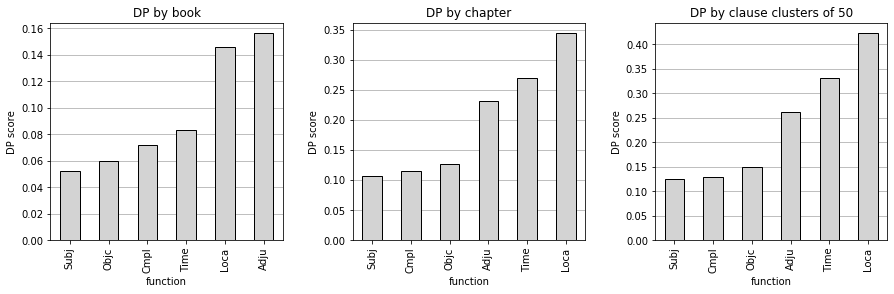

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs = axs.ravel()
titles = ['DP by book', 'DP by chapter', 'DP by clause clusters of 50']
plt.subplots_adjust(wspace=0.3)

all_dps = [book_DP, ch_DP, cl_DP]

for i, dp in enumerate(all_dps):
    ax=axs[i]
    dp.plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black')
    ax.set_xlabel('function')
    ax.set_ylabel('DP score')
    ax.grid(axis='y')
    ax.set_axisbelow(True) 
    ax.set_title(titles[i])

savefig('DP_functions')

In [39]:
DP_book_ch_cl = pd.concat(all_dps, 1, sort=True)
DP_book_ch_cl.columns = ['book DP', 'chapter DP', 'clause cl. DP']
DP_book_ch_cl = DP_book_ch_cl.loc[DP_book_ch_cl.sum(1).sort_values().index]

DP_book_ch_cl.round(2).to_clipboard()

DP_book_ch_cl

,book DP,chapter DP,clause cl. DP
Subj,0.052235,0.106514,0.124915
Cmpl,0.072055,0.115119,0.128607
Objc,0.059881,0.125964,0.149116
Adju,0.156321,0.232061,0.262407
Time,0.083187,0.268718,0.330507
Loca,0.146092,0.344149,0.422433


## Function Head Lexemes

In [40]:
head2funct = pd.pivot_table(
    functs_df[(functs_df.head_type != 'prep')], # exclude prepositional suffixed phrases (e.g. להם)
    index='head_etcbc',
    columns='function',
    aggfunc='size',
    fill_value=0
)

print(head2funct.shape)
head2funct.head()

(4212, 6)


function,Adju,Cmpl,Loca,Objc,Subj,Time
head_etcbc,,,,,,
<B/,6,6,0,4,7,0
<B=/,0,0,0,0,1,0
<B==/,0,1,0,0,0,0
<BD/,21,88,0,42,147,0
<BDH/,17,12,0,19,10,0


### Function head lexeme diversity

Determine how many head lexemes per 100 uses are found for each function.<br>
Adapted from ["Normalizing Word Counts"](http://www.thegrammarlab.com/?nor-portfolio=normalizing-word-counts).

In [41]:
is_attested = (head2funct > 0) * 1
n_attested = is_attested.sum()
head_per_100 = (n_attested / head2funct.sum()) * 100 # normalize per 100 uses of the function
head_per_100 = head_per_100.sort_values()

In [42]:
n_attested

function
Adju    1470
Cmpl    2032
Loca     352
Objc    2213
Subj    2408
Time     119
dtype: int64

In [43]:
head2funct.sum()

function
Adju     6802
Cmpl    17434
Loca     2131
Objc    16683
Subj    26540
Time     3938
dtype: int64

In [44]:
head_per_100

function
Time     3.021838
Subj     9.073097
Cmpl    11.655386
Objc    13.265000
Loca    16.518067
Adju    21.611291
dtype: float64

In [45]:
head2funct.sum(1).sort_values(ascending=False).head(25)

head_etcbc
JHWH/     3212
JWM/      1681
BN/       1397
>RY/      1378
>JC/      1169
JD/       1100
BJT/       990
<M/        980
MLK/       918
DBR/       918
HW>        904
>LHJM/     771
>NJ        733
<JN/       700
CM/        689
KL/        663
CM         654
>TH        636
DWD==/     583
JFR>L/     550
MCH=/      537
NPC/       516
<JR/       513
LB/        424
DRK/       423
dtype: int64

### Association: how associated are given head words with their attested function?

Apply Fisher's exact test for statistical significance between given functions and given head lexemes.

In [46]:
fish_head, odds_head = mystats.apply_fishers(head2funct, 0, 1, logtransform=False)
fish_head.head()

,Adju,Cmpl,Loca,Objc,Subj,Time
<B/,0.015874,0.806759,-1.000000,-0.803005,-0.667917,-6.329938e-01
<B=/,-1.000000,-1.000000,-1.000000,-1.000000,0.360951,-1.000000e+00
<B==/,-1.000000,0.237107,-1.000000,-1.000000,-1.000000,-1.000000e+00
<BD/,-0.228216,0.020234,-0.000347,-0.000229,0.000003,-1.740636e-07
<BDH/,0.000013,-0.646622,-0.417962,0.082842,-0.002360,-7.572220e-02


In [47]:
# look at number of Fisher values with positive statistical significance threshold

# total number of heads per function
total_heads = (head2funct != 0) * 1
total_heads = total_heads.sum()

# total number of statistically attracted heads per function
#sig_heads = (fish_head > 1.3) * 1  # multiply by 1 to convert T/F to 0/1 for summing

sig_heads = ((fish_head < 0.05) & (fish_head >= 0)) * 1
sig_heads = sig_heads.sum()

# proportion of statistically attracted heads per function
sig_heads_prop = sig_heads.div(total_heads).sort_values()

sig_heads_prop

Subj    0.106312
Cmpl    0.129429
Objc    0.178943
Adju    0.213605
Loca    0.448864
Time    0.487395
dtype: float64

### Get top 10 heads per function

In [48]:
def get_lexnode(lex_str):
    """Lookup lexnode for BHSA lex string"""
    node = next(
        l for l in F.otype.s('lex') 
            if F.lex.v(l) == lex_str
    )
    return node

In [49]:
top_10s = [] 

for funct in fish_head.columns:
    scores = fish_head[funct]
    positive_scores = scores[scores >= 0]
    top_scores = positive_scores.sort_values()
    raw_scores = top_scores.values
    lexs = [F.voc_lex_utf8.v(get_lexnode(l)) for l in top_scores.index]
    top_10s.append(pd.DataFrame(zip(lexs, raw_scores), columns=('lex', 'p-value')))

In [50]:
top_10_scores = pd.concat(top_10s, axis=1, keys=fish_head.columns)
top_10_scores.index = top_10_scores.index + 1
top_10_scores.index.name = 'ranks'
#top_10_scores.head(20).round(5).to_clipboard()
top_10_scores.head(20)

Adju                         Cmpl                        Loca  \
               lex        p-value           lex       p-value           lex   
ranks                                                                         
1             כֵּן  4.489966e-117         אֶרֶץ  3.044066e-84          שָׁם   
2              רֹב   3.854940e-32        בַּיִת  5.064782e-78         אֶרֶץ   
3             פֶּה   1.771411e-31  יְרוּשָׁלִַם  7.809422e-73      מִדְבָּר   
4            חֶרֶב   1.991369e-27          שָׁם  7.026717e-56           הַר   
5            אַיִן   1.600476e-24           יָד  5.956888e-50        שָׂדֶה   
6           בֶּטַח   2.527841e-24     מִצְרַיִם  8.574760e-41        בַּיִת   
7            עַיִן   2.362722e-23          עִיר  4.569925e-31  יְרוּשָׁלִַם   
8        מִשְׁפָּט   3.070512e-16        בָּבֶל  1.164167e-27        מָקֹום   
9      מִשְׁפָּחָה   5.450822e-15         אֹהֶל  1.227518e-27          פֹּה   
10         שָׁלֹום   7.893493e-15        מָקֹום  2.784354e-26         קֶרֶב   
11          עֲבוּר   3.480081e-14           הַר  1.033489e-24       שֶׁמֶשׁ   
12        רִאשֹׁון   1.004762e-13       תָּוֶךְ  1.064839e-18          חוּץ   
13        שְׁגָגָה   3.893857e-13         קֶרֶב  1.154932e-18        שַׁעַר   
14            כֹּל   6.314130e-13          רֵעַ  4.178834e-18        פֶּתַח   
15           מַעַל   7.418938e-13    יִשְׂרָאֵל  9.777122e-18      שָׁמַיִם   
16            עֹור   9.261779e-13       מַחֲנֶה  1.901773e-16      חֶבְרֹון   
17          רָצֹון   2.255574e-12           אָב  6.746101e-16       גְּבוּל   
18           מְאֹד   7.572128e-11       דֶּרֶךְ  1.014600e-14         חֹרֵב   
19       נְעוּרִים   2.056759e-10          אֵשׁ  1.367021e-14       צִיֹּון   
20          שֵׁבֶט   2.657878e-10        פֶּתַח  6.494962e-14     שֹׁמְרֹון   

                         Objc                     Subj                 \
             p-value      lex       p-value        lex        p-value   
ranks                                                                   
1      1.102680e-294      מָה  6.500823e-52       הוּא   0.000000e+00   
2       4.295061e-82   דָּבָר  3.211334e-51      אֲנִי   0.000000e+00   
3       1.454323e-64   בֶּגֶד  7.444292e-51     יְהוָה  1.953510e-299   
4       8.960971e-42  בְּרִית  1.685625e-44     אַתָּה  2.524392e-284   
5       1.353883e-23    לֶחֶם  8.474048e-41    אָנֹכִי  8.437287e-152   
6       1.023527e-20   פָּנֶה  3.612008e-35       הִיא  1.191819e-140   
7       1.824832e-20      חֵן  1.651974e-28     אַתֶּם  3.022293e-111   
8       3.048178e-20    זָהָב  1.332493e-23      אִישׁ   4.449797e-95   
9       4.097382e-19   נֶפֶשׁ  1.707805e-21     הֵמָּה   2.517290e-94   
10      8.271724e-19   כֶּסֶף  4.940494e-21        הֵם   8.534154e-84   
11      3.239393e-18  עֶרְוָה  1.327325e-20        מִי   3.687184e-73   
12      4.209399e-17     דָּם  1.909340e-20    אֲדֹנָי   8.034960e-68   
13      5.226087e-16    עֹלָה  1.756591e-18     אֵלֶּה   1.541027e-58   
14      6.657494e-16     שֵׁם  1.806465e-17     דָּוִד   3.694296e-46   
15      4.324839e-15  קְטֹרֶת  8.713390e-17  אֲנַחְנוּ   3.803066e-44   
16      4.183179e-14     יָהּ  5.523982e-15     כֹּהֵן   2.893978e-41   
17      4.973606e-14  בָּשָׂר  1.994565e-14       בֵּן   1.470871e-32   
18      2.885238e-12  שְׁבוּת  2.937790e-14        זֶה   3.478502e-31   
19      5.757907e-12     טֹוב  4.209175e-14   אֱלֹהִים   2.662677e-30   
20      2.102785e-10   אֲרֹון  1.969475e-13     מֶלֶךְ   2.148282e-28   

           Time                 
            lex        p-value  
ranks                           
1          יֹום   0.000000e+00  
2        עַתָּה   0.000000e+00  
3          עֹוד   0.000000e+00  
4        שָׁנָה  3.681151e-270  
5        עֹולָם  4.539520e-214  
6           אָז  1.000872e-161  
7           עֵת  1.857473e-157  
8       לַיְלָה  1.022951e-145  
9        בֹּקֶר  5.128073e-122  
10        עֶרֶב   1.668610e-92  
11       חֹדֶשׁ   1.382437e-73  
12      תָּמִיד   5.848000e-62  
13       פַּעַם   2.0

In [51]:
#functs_df[(functs_df.function == 'Adju') & (functs_df.head_etcbc == 'PNH/') & (functs_df.leading_prep.isin({'ל', 'מן'}))].head(25)

**Plot head lexeme diversity and association to head**

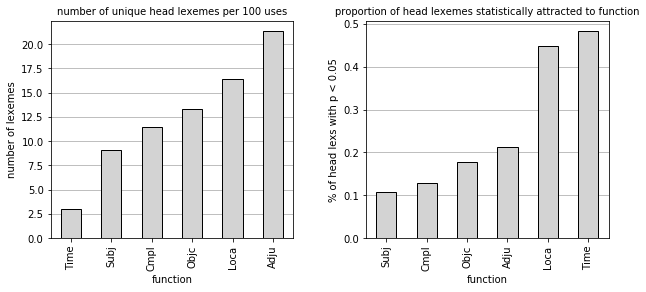

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)

head_per_100.plot(kind='bar', ax=ax1, color='lightgrey', edgecolor='black')
ax1.set_xlabel('function')
ax1.set_ylabel('number of lexemes')
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_title('number of unique head lexemes per 100 uses', size=10)

sig_heads_prop.plot(kind='bar', ax=ax2, color='lightgrey', edgecolor='black')
ax2.set_xlabel('function')
ax2.set_ylabel('% of head lexs with p < 0.05')
ax2.grid(axis='y')
ax2.set_axisbelow(True) 
ax2.set_title('proportion of head lexemes statistically attracted to function', size=10)
              
savefig('function_head_associations')
plt.show()

## Function x Component Associations

In [44]:
select_components = [
    'plural', 'suffix', 'definite', 'demonstrative', 'cardinal', 
    'ordinal', 'genitive', 'preposition', 'ø', 'qualitative',
]

In [45]:
functs_df = functs_df * 1

In [46]:
functXcomp = pd.pivot_table(
    functs_df,
    index='function',
    values=select_components,
    aggfunc='sum'
)

functXcomp

,cardinal,definite,demonstrative,genitive,ordinal,plural,preposition,qualitative,suffix,ø
function,,,,,,,,,,
Adju,101,1279,78,1552,11,1597,7535,311,2530,1974
Cmpl,121,3915,227,3556,9,3843,24373,480,12220,5436
Loca,22,589,32,508,2,262,1687,71,237,782
Objc,337,1992,289,2911,26,4137,6811,640,5970,5322
Subj,278,3212,186,3787,25,5691,110,831,3875,12616
Time,408,1343,494,409,163,639,2014,213,141,1590


In [47]:
functXcomp.to_clipboard()

In [36]:
functXcomp_dp = mystats.apply_deltaP(functXcomp, 0, 1)
functXcomp_f, oddsratios = mystats.apply_fishers(functXcomp, 0, 1, logtransform=False)

In [37]:
functXcomp_dp # ΔP scores 

,cardinal,definite,demonstrative,genitive,ordinal,plural,preposition,qualitative,suffix,ø
function,,,,,,,,,,
Adju,-0.003388,-0.013150,-0.005240,0.001978,-0.001154,-0.022615,0.163734,0.000425,-0.030681,-0.089909
Cmpl,-0.010846,-0.023781,-0.008125,-0.038989,-0.002425,-0.069745,0.242628,-0.014720,0.079996,-0.153993
Loca,-0.003799,0.055184,-0.001625,0.032417,-0.001223,-0.053096,0.105626,-0.001049,-0.123221,-0.009213
Objc,0.003648,-0.021138,0.001193,0.015822,-0.000938,0.039355,-0.075551,0.005695,0.042326,-0.010411
Subj,0.000187,0.022925,-0.003997,0.043346,-0.001081,0.091678,-0.377919,0.011723,-0.063161,0.276299
Time,0.048639,0.099387,0.060588,-0.036466,0.021442,-0.029374,-0.029842,0.011369,-0.165763,0.020019


In [39]:
oddsratios

,cardinal,definite,demonstrative,genitive,ordinal,plural,preposition,qualitative,suffix,ø
Adju,0.635090,0.839351,0.464835,1.024329,0.359256,0.786143,2.050608,1.024156,0.799440,0.506678
Cmpl,0.168896,0.733102,0.337451,0.601157,0.063963,0.466360,3.128241,0.370149,1.709676,0.326977
Loca,0.577848,1.752499,0.823174,1.415546,0.280224,0.510052,1.595541,0.940680,0.273438,0.942143
Objc,1.450017,0.750746,1.134294,1.203646,0.493142,1.433930,0.684691,1.346497,1.319602,0.935176
Subj,1.021209,1.312332,0.600799,1.615491,0.429904,2.195023,0.005847,1.781243,0.618893,4.459986
Time,9.052446,2.484553,11.743208,0.578805,41.360415,0.721840,0.864104,1.674250,0.085531,1.131067


In [40]:
functXcomp_f.round(5) # p-values for statistical significance (Fisher's exact)

,cardinal,definite,demonstrative,genitive,ordinal,plural,preposition,qualitative,suffix,ø
Adju,-0.00000,-0.0,-0.00000,0.39834,-0.00018,-0.0,0.0,0.68879,-0.0,-0.00000
Cmpl,-0.00000,-0.0,-0.00000,-0.00000,-0.00000,-0.0,0.0,-0.00000,0.0,-0.00000
Loca,-0.00752,0.0,-0.32393,0.00000,-0.05278,-0.0,0.0,-0.67919,-0.0,-0.14350
Objc,0.00000,-0.0,0.06087,0.00000,-0.00031,0.0,-0.0,0.00000,0.0,-0.00007
Subj,0.75760,0.0,-0.00000,0.00000,-0.00002,0.0,-0.0,0.00000,-0.0,0.00000
Time,0.00000,0.0,0.00000,-0.00000,0.00000,-0.0,-0.0,0.00000,-0.0,0.00003


In [41]:
def heatmap(data, center=0, **kwargs):
    """Draw seaborne heatmap with custom settings"""
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(
        data,
        center=center,
        cmap=cmap,
        square=True,
        linewidth=.5,
        **kwargs
    )

### PCA clustering of functions based on components

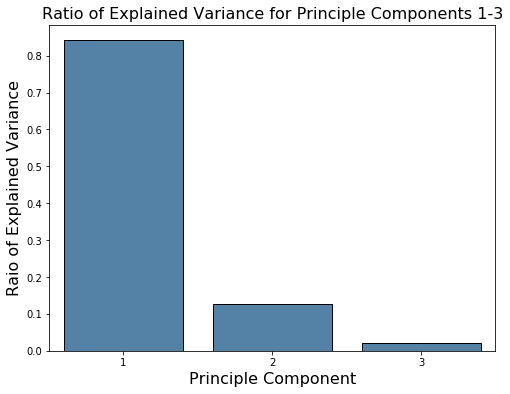

In [49]:
fc_pca, fc_loadings = my_pca.apply_pca(
    functXcomp_dp, 
    sample_axis=0, 
    feature_axis=1,
    components=3,
)

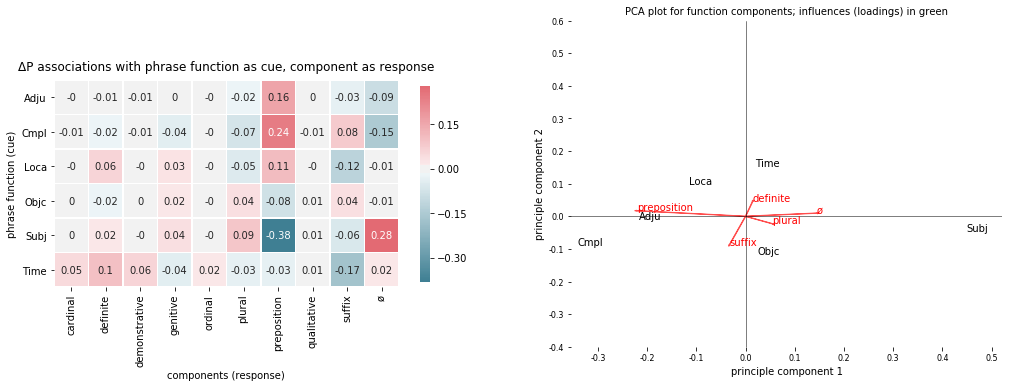

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

# plot scores
heatmap(functXcomp_dp.round(2), ax=ax1, annot=True, cbar_kws={'shrink': 0.6})
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_title('ΔP associations with phrase function as cue, component as response', pad=10)
ax1.set_xlabel('components (response)')
ax1.set_ylabel('phrase function (cue)')

# plot PCA
x, y = fc_pca['PC1'], fc_pca['PC2']
ax2.scatter(x, y, s=9, color='')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)
ax2.set_xlabel('principle component 1')
ax2.set_ylabel('principle component 2')
ax2.set_title('PCA plot for function components; influences (loadings) in green', size=10)
#ax2.axis('equal')
ax2.set_yticks(ax2.get_xticks())

# Hide the spines but keep the ticks
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_yticklabels(ax2.get_yticks().round(1), size=8)
ax2.set_xticklabels(ax2.get_xticks().round(1), size=8)

# plot function labels
xoff = -0.03
yoff = -0.002
for i, function in enumerate(fc_pca.index):
    ax2.text(x[i]+xoff, y[i]+yoff, function)
    
# plot loadings arrows + labels (scree plot)
loads = fc_loadings.T[[1, 2]].loc[fc_loadings.T[[1, 2]].abs().sum(1).sort_values(ascending=False).index][:5]
for l in loads.index:
    x,y = loads.loc[l]
    ax2.arrow(0, 0, x, y, color='#ff4d4d')
    ax2.text(x, y, l, color='red', size=10)

savefig('function_comps_clusters')

## Component x Component Associations

In [105]:
comps_data = {}
dp_comps = {}

functions = [
    'Time',
    'Loca',
    'Adju',
    'Cmpl',
    'Objc',
    'Subj',
]

for funct in functions:

    funct_data = functs_df[functs_df.function == funct]
    comps = funct_data[select_components] * 1 # mult by 1 turns T/F into 1/0
    comps = comps.T.dot(comps) # dot product for pairwise
    np.fill_diagonal(comps.values, 0) # ignore diagonals
    comps_data[funct] = comps
    
    deltaP_comps = mystats.apply_deltaP(comps, 0, 1)
    np.fill_diagonal(deltaP_comps.values, 0)
    dp_comps[funct] = deltaP_comps

In [106]:
dp_comps.keys()

dict_keys(['Time', 'Loca', 'Adju', 'Cmpl', 'Objc', 'Subj'])

In [107]:
dp_comps['Time']

,plural,suffix,definite,demonstrative,cardinal,ordinal,genitive,preposition,ø,qualitative
plural,0.000000,0.077211,-0.099261,-0.069918,0.234746,-0.041054,0.043208,-0.062404,-0.054232,0.101963
suffix,0.299484,0.000000,-0.215232,-0.115566,-0.038484,-0.037331,-0.056689,0.193862,-0.049314,0.047039
definite,-0.061132,-0.034175,0.000000,0.190244,-0.040591,0.063752,-0.069767,0.257293,-0.060692,0.019958
demonstrative,-0.071435,-0.030441,0.315602,0.000000,-0.042188,-0.040925,-0.062145,0.151969,-0.054061,-0.039688
cardinal,0.664111,-0.028069,-0.186459,-0.116818,0.000000,-0.037736,-0.041750,-0.125863,-0.049849,-0.038668
ordinal,-0.119591,-0.028036,0.301536,-0.116682,-0.038855,0.000000,-0.057236,0.184970,-0.049791,-0.038623
genitive,0.084538,-0.028595,-0.221642,-0.119008,-0.028874,-0.038443,0.000000,0.399472,-0.050783,0.061713
preposition,-0.029158,0.023353,0.195200,0.069499,-0.020787,0.029669,0.095398,0.000000,0.149129,-0.037923
ø,-0.121055,-0.028380,-0.219972,-0.118111,-0.039331,-0.038154,-0.057937,0.712435,0.000000,-0.039096
qualitative,0.290130,0.034507,0.092208,-0.110534,-0.038891,-0.037727,0.089750,-0.230947,-0.049837,0.000000


In [155]:
max_score = max(table.max().max() for table in dp_comps.values())
min_score = min(table.min().min() for table in dp_comps.values())

In [156]:
min_score

-0.39742246437552387

In [157]:
max_score

0.9872170997485331

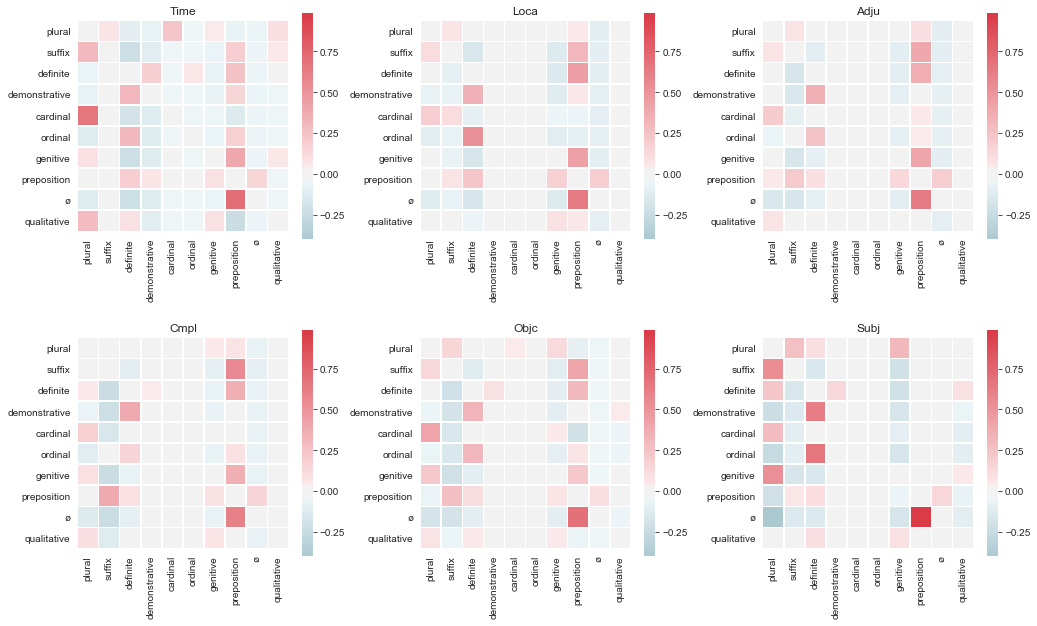

In [174]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3, hspace=0.4)

for i, funct in enumerate(functions):
    heatmap(dp_comps[funct], ax=axs[i], vmin=min_score, vmax=max_score)
    axs[i].set_title(funct)

savefig('comp_comp_ΔP_function')
plt.show()

Unique to Time:

* plural is more predictive of cardinal, vice versa


### Build a Gephi network

We will export these scores in the form of edges in a Gephi network.

In [178]:
gephi_dir = Path('../gephi/adverbial_components/')

for funct in functions:

    gephi_nodes = pd.DataFrame(dp_comps[funct].index)
    gephi_nodes.columns=['Label']
    gephi_nodes.index.name = 'ID'

    edge_data = []
    for i1, comp1 in enumerate(dp_comps[funct].index):
        for i2, comp2 in enumerate(dp_comps[funct].columns):
            weight = round(dp_comps[funct].loc[comp1][comp2], 2)
            if weight and weight > 0:
                edge_data.append((i1, i2, weight))

    gephi_edges = pd.DataFrame(edge_data, columns=['Source', 'Target', 'Weight'])

    gephi_nodes.to_csv(gephi_dir.joinpath(f'{funct}_comp_nodes.csv'))
    gephi_edges.to_csv(gephi_dir.joinpath(f'{funct}_comp_edges.csv'), index=False)

**Gephi graph with ΔP as edge weight and Force Atlas 2**

<img src="../gephi/adverbial_components/Time_graph.svg" height="40%" width="40%">

In the graph we can make out 6 sub-networks:

* plural, cardinal
* suffix, plural, preposition
* genitive, plural, preposition
* definite, demonstrative, preposition
* definite, ordinal, preposition
* bare, preposition

## ΔP with Preposition Lexemes

In [86]:
prep_comps = times_subset[['leading_prep', 'time_pl', 'time_sffx', 'demonstrative', 'cardinal', 'ordinal', 'genitive', 'bare']] * 1
raw_prepXcomp = prep_comps.groupby('leading_prep').sum()
prepXcomp = raw_prepXcomp[raw_prepXcomp.sum(1) > 20]
prepXcomp

,time_pl,time_sffx,demonstrative,cardinal,ordinal,genitive,bare
leading_prep,,,,,,,
ø,334,16,34,323,4,60,49
אחר,13,4,13,1,0,10,0
ב,125,51,341,19,135,225,3
ל,47,14,3,10,1,22,1
מן,38,6,3,20,0,17,3
עד,3,0,74,0,3,29,14


In [87]:
dp_prepXcomp = mystats.apply_deltaP(prepXcomp, 0, 1)

dp_prepXcomp

,time_pl,time_sffx,demonstrative,cardinal,ordinal,genitive,bare
leading_prep,,,,,,,
ø,0.226227,-0.040584,-0.306293,0.353838,-0.106500,-0.169618,0.042929
אחר,0.047216,0.054640,0.092604,-0.159132,-0.070548,0.069753,-0.034534
ב,-0.233070,0.022512,0.270670,-0.281688,0.143323,0.132228,-0.053977
ל,0.219186,0.103771,-0.205428,-0.082223,-0.061877,0.051393,-0.024821
מן,0.173278,0.026058,-0.200247,0.051692,-0.072186,0.020743,0.000661
עד,-0.261985,-0.046787,0.399055,-0.191774,-0.047589,0.064050,0.085029


In [176]:
# fig,ax = plt.subplots(figsize=(8, 5))
# sns.heatmap(dp_prepXcomp, ax=ax, robust=True, center=0)
# ax.set_yticklabels((get_display(prep) for prep in dp_prepXcomp.index), rotation=0, size=12)
# plt.show()

In [268]:
times_subset[(times_subset.leading_prep == 'ל') & times_subset.time_sffx]

,ref,book,ph_type,text,token,clause,classi,time,time_etcbc,time_pos,...,qual_str,demonstrative,demon_str,demon_dist,ordinal,ord_str,cl_kind,verb,tense,verb_lex
node,,,,,,,,,,,,,,,,,,,,,
1446970,Gen 27:7,Genesis,prep_ph,לִפְנֵ֥י מֹותִֽי׃,ל.פנה.מות,וַאֲבָרֶכְכָ֛ה לִפְנֵ֥י יְהוָ֖ה לִפְנֵ֥י מֹותִ...,single.prep.suffix,מות,MWT/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,yqtl,ברך
1446972,Gen 27:10,Genesis,prep_ph,לִפְנֵ֥י מֹותֹֽו׃,ל.פנה.מות,בַּעֲבֻ֛ר אֲשֶׁ֥ר יְבָרֶכְךָ֖ לִפְנֵ֥י מֹותֹֽו׃,single.prep.suffix,מות,MWT/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,yqtl,ברך
1447000,Gen 30:30,Genesis,prep_ph,לְפָנַי֙,ל.פנה,אֲשֶׁר־הָיָ֨ה לְךָ֤ לְפָנַי֙,single.prep.suffix,פנה,PNH/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,qtl,היה
1447116,Gen 50:16,Genesis,prep_ph,לִפְנֵ֥י מֹותֹ֖ו,ל.פנה.מות,אָבִ֣יךָ צִוָּ֔ה לִפְנֵ֥י מֹותֹ֖ו,single.prep.suffix,מות,MWT/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,qtl,צוה
1447170,Exod 10:14,Exodus,prep_ph,לְ֠פָנָיו,ל.פנה,לְ֠פָנָיו לֹא־הָ֨יָה כֵ֤ן אַרְבֶּה֙ כָּמֹ֔הוּ,single.prep.suffix,פנה,PNH/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,qtl,היה
1447188,Exod 12:14,Exodus,prep_ph,לְדֹרֹ֣תֵיכֶ֔ם,ל.דור,וְחַגֹּתֶ֥ם אֹתֹ֖ו חַ֣ג לַֽיהוָ֑ה לְדֹרֹ֣תֵיכֶ֔ם,single.prep.suffix,דור,DWR/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,qtl,חגג
1447194,Exod 12:17,Exodus,prep_ph,לְדֹרֹתֵיכֶ֖ם,ל.דור,וּשְׁמַרְתֶּ֞ם אֶת־הַיֹּ֥ום הַזֶּ֛ה לְדֹרֹתֵיכ...,single.prep.suffix,דור,DWR/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,wqtl,שׁמר
1447204,Exod 12:42,Exodus,prep_ph,לְדֹרֹתָֽם׃ פ,ל.דור,הֽוּא־הַלַּ֤יְלָה הַזֶּה֙ לַֽיהוָ֔ה שִׁמֻּרִ֛י...,single.prep.suffix,דור,DWR/,subs,...,NaN,False,NaN,NaN,False,NaN,NC,False,NaN,NaN
1447361,Exod 40:15,Exodus,prep_ph,לְדֹרֹתָֽם׃,ל.דור,לִהְיֹ֨ת לָהֶ֧ם מָשְׁחָתָ֛ם לִכְהֻנַּ֥ת עֹולָ֖...,single.prep.suffix,דור,DWR/,subs,...,NaN,False,NaN,NaN,False,NaN,VC,True,infc,היה


In [277]:
times_subset[times_subset.time_sffx & times_subset.cardinal]

,ref,book,ph_type,text,token,clause,classi,time,time_etcbc,time_pos,...,qual_str,demonstrative,demon_str,demon_dist,ordinal,ord_str,cl_kind,verb,tense,verb_lex
node,,,,,,,,,,,,,,,,,,,,,
